# BERT Text Classification - Multiclass dataset

This experiment aims to use BERT for text classification on the DMoz Computers dataset, available at The data used here is available in the [Text Collections](https://github.com/ragero/text-collections/tree/master/complete_texts_csvs) Github repo.

The code in this notebook was heavily inspired by the Chapter 2 of the book [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/).

## Dependencies installation

In [ ]:
!pip install datasets evaluate accelerate
!pip install "numpy<2.0"

## Data

In [2]:
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split

dataset = load_dataset("csv", data_files="/content/Dmoz-Computers.csv")
dataset = dataset.rename_column("class", "label")

# We want to stratify the split based on labels occurrence
df = dataset["train"].to_pandas()

# Whole dataset into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)

# Temp into validation (10%) and test (20%) with stratification
valid_df, test_df = train_test_split(temp_df, test_size=2/3, stratify=temp_df["label"], random_state=42)

# Back to HuggingFace interface
dataset = DatasetDict({
    'train': dataset["train"].from_pandas(train_df),
    'validation': dataset["train"].from_pandas(valid_df),
    'test': dataset["train"].from_pandas(test_df)
})

print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__'],
        num_rows: 6650
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__'],
        num_rows: 950
    })
    test: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__'],
        num_rows: 1900
    })
})


## Mapping labels to integer

The classification model asks for a number label instead of a string label.

In [3]:
label_names = [
    'Artificial',
    'CAD',
    'Companies',
    'Computer',
    'Consultants',
    'Data',
    'Education',
    'Graphics',
    'Hardware',
    'Internet',
    'Mobile',
    'Multimedia',
    'Open',
    'Programming',
    'Robotics',
    'Security',
    'Software',
    'Systems'
]

label_mapping = {label: idx for idx, label in enumerate(label_names)}

In [4]:
def map_to_int(example, label_mapping: dict):
  int_label = label_mapping.get(example["label"])
  example["label"] = int_label
  return example

In [5]:
# sanity check for the mapping function
labels = set()
for elem in dataset["train"]:
  labels.add(elem["label"])

print(labels)

{'Computer', 'Systems', 'Security', 'Internet', 'Programming', 'Data', 'Open', 'Graphics', 'Multimedia', 'Software', 'Artificial', 'Hardware', 'Mobile', 'Education', 'Consultants', 'Robotics', 'Companies', 'CAD'}


In [ ]:
dataset = dataset.map(lambda x: map_to_int(x, label_mapping))

## Tokenization

An exploration of how the distilbert tokenizer behaves.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [8]:
# tokenizer example
s = "Tolkien was a great writer."
encoded_text = tokenizer(s)
print(encoded_text)

{'input_ids': [101, 23602, 2001, 1037, 2307, 3213, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'tolkien', 'was', 'a', 'great', 'writer', '.', '[SEP]']


In [10]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tolkien was a great writer. [SEP]


Let's define a helper function and see how its behave in one example.

In [11]:
def tokenize(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [12]:
print(tokenize(dataset["train"][0]))

{'input_ids': [101, 1996, 10994, 4948, 6786, 9722, 1997, 1996, 3786, 5302, 9247, 1056, 2487, 13354, 1011, 1999, 5308, 3622, 2595, 5746, 6364, 13354, 1011, 16021, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [13]:
print(dataset["train"][0]["label"])

11


For the whole data now!

In [ ]:
encoded_data = dataset.map(tokenize, batched=True)

In [15]:
print(encoded_data["train"].column_names)

['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']


In [16]:
encoded_data

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6650
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 950
    })
    test: Dataset({
        features: ['file_name', 'text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

## Training

I chose the distilbert flavor because it is lighter than the origin BERT.

In [ ]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [18]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [19]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [20]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [21]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [22]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [23]:
encoded_data.set_format("torch", columns=['file_name', 'text', 'label', 'input_ids', 'attention_mask'])

In [ ]:
data_hidden = encoded_data.map(extract_hidden_states, batched=True, batch_size=100)

Text classification -> Sequence Classification flavor in the HuggingFace framework.

In [25]:
from transformers import AutoModelForSequenceClassification
num_labels = len(label_names)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

For HuggingFace Login!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(encoded_data["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-dmoz-computers"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
    report_to=None
)

Here we have a multiclass classification problem, so we have to define a loss function that can handle correctly the multiclass schema.

In [ ]:
import torch
from torch import nn
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # nll loss forward is not implemented for int in cuda, so we use .long()
        labels = inputs.pop("labels").long()

        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["validation"],
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mstauffer to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.194300,1.509426,0.625263,0.609763
2,1.241800,1.089966,0.704211,0.689352
3,0.860800,0.935125,0.737895,0.727279
4,0.640800,0.902608,0.742105,0.739716
5,0.486500,0.886702,0.754737,0.754582
6,0.374100,0.894412,0.745263,0.743040
7,0.291400,0.888966,0.751579,0.752407
8,0.233600,0.897049,0.760000,0.761266
9,0.203200,0.903409,0.756842,0.757775
10,0.177500,0.901512,0.756842,0.757619


Pushing the model to my HuggingFace page. It is available at https://huggingface.co/mstauffer/distilbert-base-uncased-finetuned-dmoz-computers.

In [ ]:
trainer.push_to_hub()

## Evaluation

Here we have the classification report and confusion matrix in the test set.

In [32]:
trainer.evaluate(encoded_data["test"])

{'eval_loss': 0.9558384418487549,
 'eval_accuracy': 0.7473684210526316,
 'eval_f1': 0.7469815566467953,
 'eval_runtime': 8.3743,
 'eval_samples_per_second': 226.886,
 'eval_steps_per_second': 7.165,
 'epoch': 10.0}

In [33]:
test_preds = trainer.predict(encoded_data['test'])

              precision    recall  f1-score   support

  Artificial       0.79      0.85      0.82       100
         CAD       0.80      0.83      0.81       100
   Companies       0.60      0.61      0.61       100
    Computer       0.77      0.82      0.79       100
 Consultants       0.68      0.74      0.71       100
        Data       0.80      0.81      0.81       200
   Education       0.89      0.87      0.88       100
    Graphics       0.86      0.90      0.88       100
    Hardware       0.74      0.73      0.74       100
    Internet       0.76      0.65      0.70       100
      Mobile       0.87      0.76      0.81       100
  Multimedia       0.63      0.72      0.67       100
        Open       0.73      0.76      0.75       100
 Programming       0.61      0.61      0.61       100
    Robotics       0.95      0.92      0.93       100
    Security       0.87      0.79      0.83       100
    Software       0.36      0.34      0.35       100
     Systems       0.71    

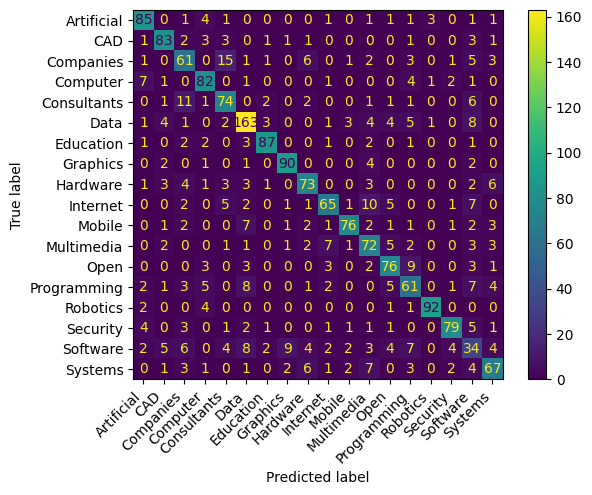

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

y_true = test_preds.label_ids
y_pred = np.argmax(test_preds.predictions, axis=1)

print(classification_report(
    y_true=y_true,
    y_pred=y_pred,
    labels=list(range(len(label_names))),
    target_names=label_names
))

ConfusionMatrixDisplay.from_predictions(y_true=test_preds.label_ids,
                                        y_pred=np.argmax(test_preds.predictions, axis=1),
                                        display_labels=label_names)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

## Comparision with a baseline model

Numbers of a standard SVM + TF-IDF model on the same split.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

tfidf = TfidfVectorizer()

X_train_csr = tfidf.fit_transform(train_df["text"])
X_test_csr = tfidf.transform(test_df["text"])

svm = SVC()

svm.fit(X_train_csr, [label_mapping.get(elem) for elem in train_df["label"]])

preds_svm = svm.predict(X_test_csr)

              precision    recall  f1-score   support

  Artificial       0.82      0.71      0.76       100
         CAD       0.90      0.74      0.81       100
   Companies       0.73      0.62      0.67       100
    Computer       0.78      0.82      0.80       100
 Consultants       0.66      0.71      0.69       100
        Data       0.42      0.86      0.56       200
   Education       0.95      0.81      0.88       100
    Graphics       0.94      0.89      0.91       100
    Hardware       0.84      0.65      0.73       100
    Internet       0.83      0.59      0.69       100
      Mobile       0.92      0.70      0.80       100
  Multimedia       0.67      0.60      0.63       100
        Open       0.64      0.65      0.64       100
 Programming       0.51      0.46      0.48       100
    Robotics       0.93      0.84      0.88       100
    Security       0.85      0.61      0.71       100
    Software       0.42      0.38      0.40       100
     Systems       0.73    

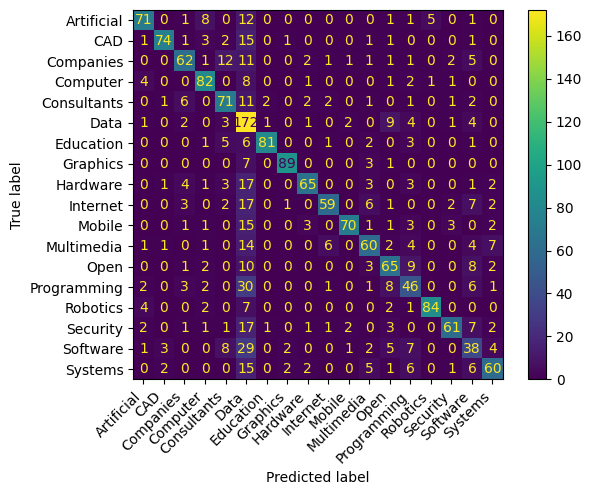

In [36]:
print(classification_report(
    y_true=test_preds.label_ids,
    y_pred=preds_svm,
    labels=list(range(len(label_names))),
    target_names=label_names
))


ConfusionMatrixDisplay.from_predictions(y_true=test_preds.label_ids,
                                        y_pred=preds_svm,
                                        display_labels=label_names)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

BERT wins! This time by a small margin, but _a win is a win_. See ya, dear reader :)